# Defining Functions

In [1]:
import pandas as pd
import json
# load the data in one single dataframe
def load_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return pd.DataFrame(data)

In [2]:
def refactor(df):# Extract all utterances from the dialogues
    all_utterances = []

    for _, row in df.iterrows():
        # Each row has an 'utterances' field which is a list of utterance dictionaries
        utterances = row['utterances']

        # Add dialogue ID and topic to each utterance for reference
        for utterance in utterances:
            utterance['dialogue_id'] = row['id']
            utterance['topic'] = row['topic']
            all_utterances.append(utterance)

    # Convert to DataFrame for easier analysis
    df = pd.DataFrame(all_utterances)
    return df

## Loading Dataset

In [3]:
df = load_data('hand_labelled_dataset.json')

In [4]:
refactor_df = refactor(df)

## Create a new column "hats" with a list of all the hats in the dialog

In [5]:
# make a for loop, for every 'utterances' element in the dataframe, extract the values of "hat" element and save it as list of strings in another column
df['hats'] = df['utterances'].apply(lambda x: [item['hat'] for item in x])

## Create a new column "most_frequent_hat" with the most frequent hat for each dialogue

In [6]:
# for each row of df get the most frequent value of the "hat" column and save it in a new column called "most_frequent_hat"
df['most_frequent_hat'] = df['hats'].apply(lambda x: pd.Series(x).mode()[0] if not pd.Series(x).mode().empty else None)

## Check the distribution of most_frequent_hat column

In [7]:
# !pip install matplotlib

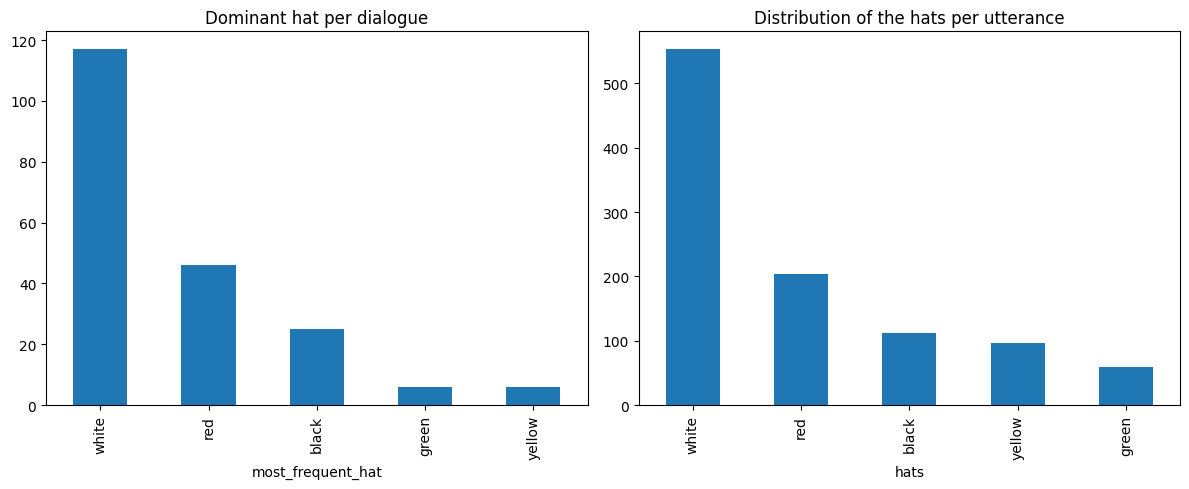

In [8]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 riga, 2 colonne

# Primo plot: most frequent hat per dialogo
df['most_frequent_hat'].value_counts().plot(kind='bar', ax=axes[0])
axes[0].set_title('Dominant hat per dialogue')
axes[0].set_xlabel('most_frequent_hat')

# Secondo plot: tutte le occorrenze dei cappelli (per frase)
df['hats'].explode().value_counts().plot(kind='bar', ax=axes[1])
axes[1].set_title('Distribution of the hats per utterance')
axes[1].set_xlabel('hats')

plt.tight_layout()
plt.show()

## follow the minority class

In [9]:
import pandas as pd

# esempio: il tuo DataFrame
# df = pd.DataFrame({'text': [...], 'hat': [...]})

# ottieni il numero minimo tra le classi
min_samples = refactor_df['hat'].value_counts().min()

# per ogni classe, prendi un campione casuale di min_samples
balanced_df = refactor_df.groupby('hat').sample(n=min_samples, random_state=42)

# resetta gli indici
balanced_df = balanced_df.reset_index(drop=True)


## up to 100 per class

In [10]:
def balanced_subsample(df, label_col, min_size=None, max_per_class=None):
    vc = df[label_col].value_counts()
    if min_size is None:
        min_size = vc.min()
    if max_per_class is None:
        max_per_class = min_size

    frames = []
    for label in vc.index:
        n = min(vc[label], max_per_class)
        frames.append(df[df[label_col] == label].sample(n=n, random_state=42))
    return pd.concat(frames).reset_index(drop=True)

# esempio:
balanced_df = balanced_subsample(refactor_df, label_col='hat', max_per_class=100)

In [11]:
# print balanced_df distribution 
print(balanced_df['hat'].value_counts())

hat
white     100
red       100
black     100
yellow     97
green      59
Name: count, dtype: int64


In [12]:
# output the balanced dataframe to a csv file
balanced_df.to_csv('balanced_dataset_100_each.csv', index=False)

In [13]:
# output the balanced dataframe to a json file
balanced_df.to_json('balanced_dataset_100_each.json', orient='records', lines=True, force_ascii=False)